## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [29]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calibrate the camera using the objpoints and imgpoints


Text(0.5,1,'Undistorted Image')

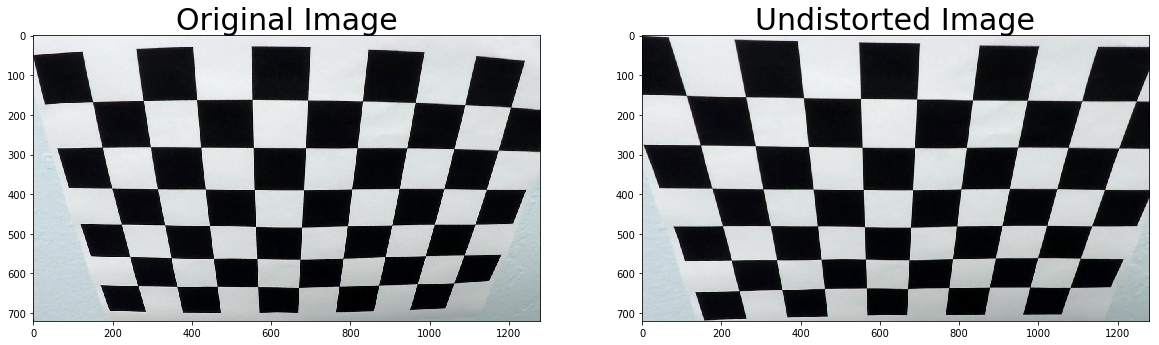

In [30]:
%matplotlib inline

img = cv2.imread('./camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Threshold methods

In [31]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)

    # scale the image to 8 bit (0 - 255)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    #create a binary mask where the threshold parameters are met
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary



def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi / 2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Use arctan to get the direction of the gradient
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # create a binary mask based on the thresholds passed
    dir_binary = np.zeros_like(gradient_direction)
    dir_binary[(gradient_direction >= thresh[0]) & (gradient_direction <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255), channel='S'):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    if channel == 'H':
        channel = H
    elif channel == 'L':
        channel = L
    else:
        channel = S
    
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

## Testing the threshold methods

Text(0.5,1,'Thresholds combined')

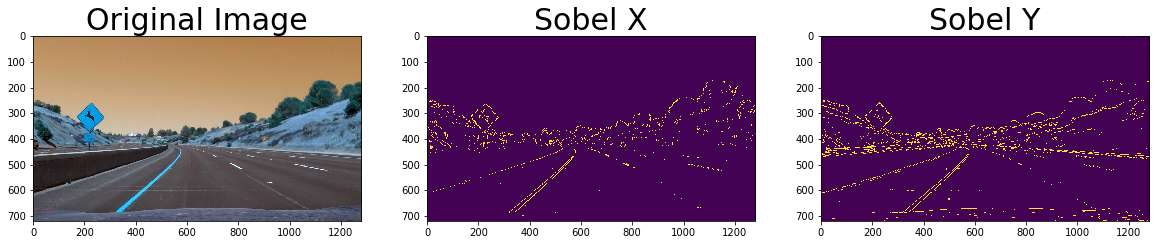

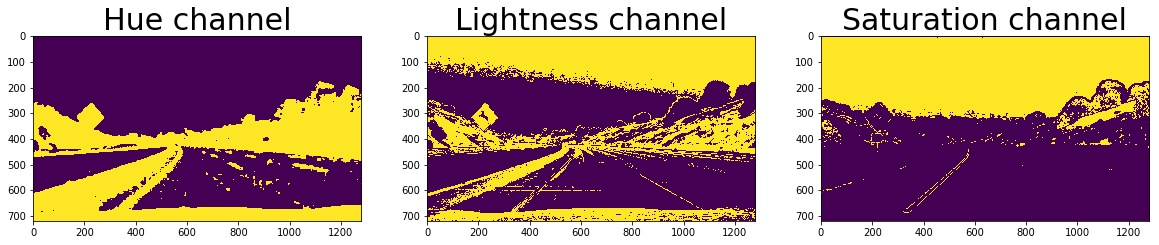

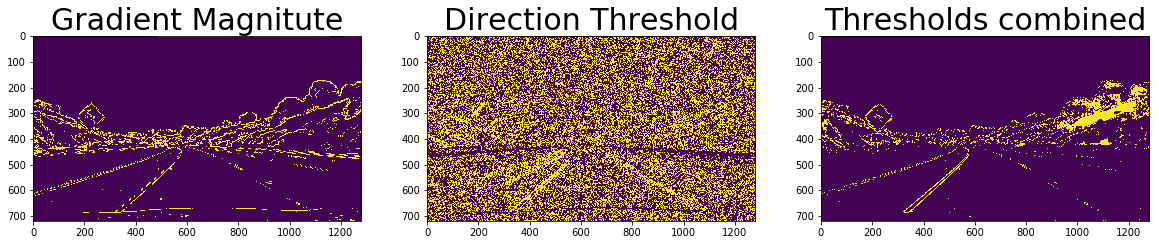

In [34]:
%matplotlib inline

ksize = 7
image = cv2.imread('./test_images/test2.jpg')

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 100))
#print(gradx, grady)

mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

hue_binary = hls_select(images, thresh=(90, 150), channel='H')
light_binary = hls_select(images, thresh=(90, 150), channel='L')
sat_binary = hls_select(images, thresh=(90, 150), channel='S')

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((sat_binary == 1) & (hue_binary == 1))] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(gradx)
ax2.set_title('Sobel X', fontsize=30)
ax3.imshow(grady)
ax3.set_title('Sobel Y', fontsize=30)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(hue_binary)
ax1.set_title('Hue channel', fontsize=30)
ax2.imshow(light_binary)
ax2.set_title('Lightness channel', fontsize=30)
ax3.imshow(sat_binary)
ax3.set_title('Saturation channel', fontsize=30)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(mag_binary)
ax1.set_title('Gradient Magnitute', fontsize=30)
ax2.imshow(dir_binary)
ax2.set_title('Direction Threshold', fontsize=30)
ax3.imshow(combined)
ax3.set_title('Thresholds combined', fontsize=30)

## Perspective transform to get the bird's eye  view